Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
Classification Report:
                     precision    recall  f1-score   support

  Bertemu Keluarga       1.00      1.00      1.00     10279
           Lainnya       1.00      1.00      1.00      4742
Memperbaiki Barang       1.00      0.99      1.00       185
   Pergi ke Klinik       1.00      1.00      1.00       232
      Tamat Kuliah       1.00      0.98      0.99       226
      Tugas Kuliah       1.00      1.00      1.00       292
    Urusan Pribadi       1.00      1.00      1.00       118

          accuracy                           1.00     16074
         macro avg       1.00      1.00      1.00     16074
      weighted avg       1.00      1.00      1.00     16074



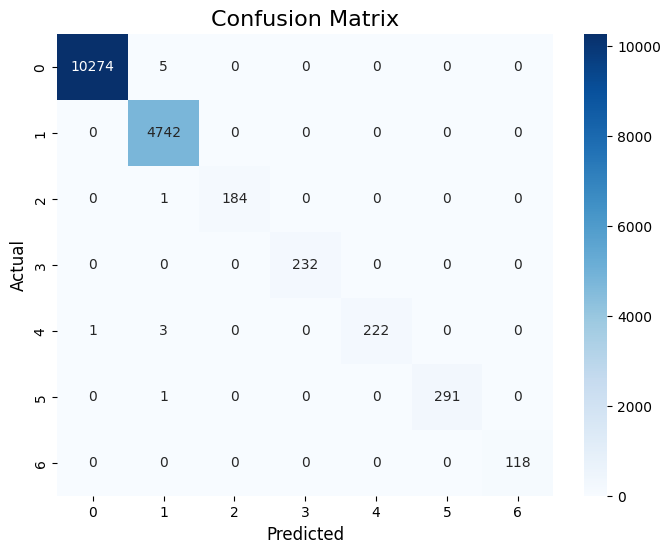

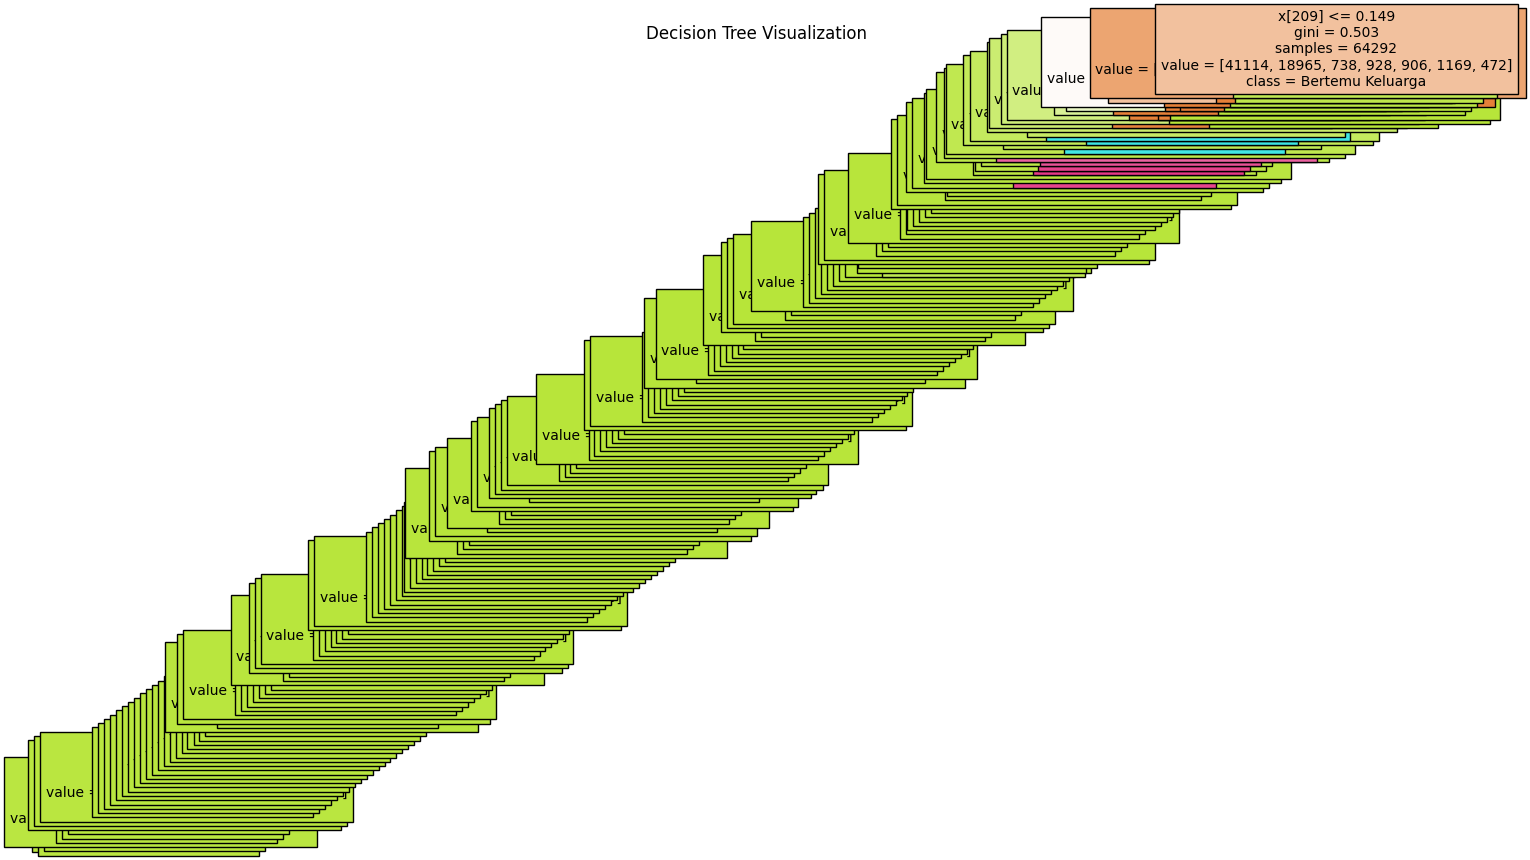

ValueError: Can only compare identically-labeled Series objects

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter

# Step 1: Load datasets
file_path = 'dataset.xlsx'  # Ubah ke lokasi file Anda
data_ik = pd.read_excel(file_path, sheet_name='DATA IK')
data_ib = pd.read_excel(file_path, sheet_name='DATA IB')

# Step 2: Preprocessing - Combine and clean data
data_ik = data_ik[['tujuan']].rename(columns={'tujuan': 'keperluan'})
data_ib = data_ib[['desc']].rename(columns={'desc': 'keperluan'})
data_combined = pd.concat([data_ik, data_ib], ignore_index=True)
data_combined.dropna(subset=['keperluan'], inplace=True)

# Step 3: Clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Menghapus simbol dan angka
    text = re.sub(r"\s+", " ", text).strip()  # Menghapus whitespace berlebih
    return text

data_combined['keperluan'] = data_combined['keperluan'].apply(clean_text)

# Step 4: Categorize "keperluan"
def classify_keperluan(text):
    if re.search(r"(laptop|printer|service|barang)", text):
        return "Memperbaiki Barang"
    elif re.search(r"(orangtua|keluarga|pulang|rumah|bertemu)", text):
        return "Bertemu Keluarga"
    elif re.search(r"(proyek|PKM|tugas|makalah|observasi|akhir|data)", text):
        return "Tugas Kuliah"
    elif re.search(r"(kontrol|gigi|sakit|berobat|obat)", text):
        return "Pergi ke Klinik"
    elif re.search(r"(membeli|pribadi|mengurus|rekening|tabungan)", text):
        return "Urusan Pribadi"
    elif re.search(r"(wisuda|graduation|clearance)", text):
        return "Tamat Kuliah"
    else:
        return "Lainnya"

data_combined['kategori'] = data_combined['keperluan'].apply(classify_keperluan)

# Step 5: TF-IDF Vectorization
factory = StopWordRemoverFactory()
stop_words_indonesian = factory.get_stop_words()

vectorizer = TfidfVectorizer(max_features=500, stop_words=stop_words_indonesian)
X = vectorizer.fit_transform(data_combined['keperluan']).toarray()
y = data_combined['kategori']

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Hyperparameter Tuning for Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15]
}
grid_search = GridSearchCV(dt_model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters for Decision Tree:", best_params)

# Train the Decision Tree with best parameters
dt_model = DecisionTreeClassifier(random_state=42, **best_params)
dt_model.fit(X_train, y_train)

# Step 8: Evaluate Model
y_pred = dt_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Step 9: Visualize Decision Tree
plt.figure(figsize=(16, 10))
plot_tree(dt_model, class_names=dt_model.classes_, filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

# Step 10: K-Means Clustering
pca = PCA(n_components=2)  # Reduksi ke 2 dimensi
X_pca = pca.fit_transform(X)

# Tentukan jumlah cluster (misalnya 5 cluster)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=20).fit(X_pca)
data_combined['Cluster'] = kmeans.labels_

# Step 11: Identifikasi kategori dominan per cluster
cluster_summary = data_combined.groupby('Cluster')['kategori'].agg(lambda x: x.mode()[0]).reset_index()
cluster_summary['Persentase'] = data_combined.groupby('Cluster')['kategori'].apply(lambda x: (x == cluster_summary['kategori']).sum() / len(x) * 100).values

# Step 12: Map Peluang Bisnis untuk setiap cluster
recommendations = {
    "Bertemu Keluarga": "Jasa Transportasi",
    "Pergi ke Klinik": "Klinik Kesehatan atau Apotek",
    "Tugas Kuliah": "Pusat Fotokopi atau Jasa Pengetikan",
    "Memperbaiki Barang": "Toko Elektronik atau Reparasi Barang",
    "Urusan Pribadi": "Layanan Logistik atau Pengurusan Dokumen",
    "Tamat Kuliah": "Jasa Fotografi atau Penyewaan Kostum",
    "Lainnya": "Usaha General seperti Minimarket"
}

cluster_summary['Peluang Bisnis'] = cluster_summary['kategori'].map(recommendations)

# Step 13: Tampilkan hasil
print(cluster_summary)

# Optional: Visualisasi hasil clustering
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data_combined['Cluster'], cmap='viridis', marker='o', s=30)
plt.title("KMeans Clustering Visualization (2D)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.grid(True)
plt.show()

# Step 14: Export data dengan cluster
data_combined.to_csv("data_with_clusters.csv", index=False)
